In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath('../01.model'))

from model_deeplift import TransformerModel
from SingleCellDataset import SingleCellDataset
from create_dataloaders import create_dataloaders
from load_data import load_data
from set_seed import set_seed


In [2]:
### GPU
device = torch.device(f'cuda:{5}' if torch.cuda.is_available() else 'cpu')

In [3]:
### load data set
data_path = "../00.preprocessing/101_2981_4118.pth"
expr_tensor, expr_mask, disease_tensor, meta_tensor, celltype_tensor, target_tensor= load_data(data_path, device)
dataset = SingleCellDataset(expr_tensor, expr_mask, disease_tensor, meta_tensor, celltype_tensor, target_tensor)
train_loader, val_loader = create_dataloaders(
    dataset,
    batch_size=16,
    train_ratio=0.8,
    bins=6,
    seed=14
)

/pool1/liujianhong/prj/20250530_scPIT_review/01.model/load_data.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensors = torch.load(data_path)


expr_tensortorch.Size([101, 2891, 4118])
expr_masktorch.Size([101, 2891])
disease_tensortorch.Size([101])
meta_tensortorch.Size([101, 3])
celltype_tensortorch.Size([101, 2891])
target_tensortorch.Size([101])
---------------------------------------------
Data Statistics:
Number of samples: 101
Number of cells per sample: 2891
Number of genes: 4118
Valid cells ratio: 25.57%
FEV1 range: [-2.48, 2.59]
meta_tensor: torch.Size([101, 3])
target_tensor: torch.Size([101])
Bin 0 has less than 2 samples (1 samples), adding to training set.
Bin 6 has less than 2 samples (1 samples), adding to training set.
---------------------------------------------
Train Mean: 0.0061, Std: 1.0111
Val Mean: -0.0220, Std: 0.9589
Number of Train Samples: 79
Number of Validation Samples: 22
---------------------------------------------


In [4]:
### model
model = TransformerModel(
    gene_count=4118,
    dim=128
).to(device)

In [5]:
### load checkpoint
model_weight = torch.load('../02.checkpoint/model_weights.pth')
model.load_state_dict(model_weight)
model.eval()

/tmp/ipykernel_3216289/88074908.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weight = torch.load('../02.checkpoint/model_weights.pth')


TransformerModel(
  (cell_mlp): Sequential(
    (0): Linear(in_features=4118, out_features=2048, bias=True)
    (1): ReLU()
    (2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=2048, out_features=512, bias=True)
    (4): ReLU()
    (5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (no

In [6]:
### Vaildation set

expr_list = []
mask_list = []
meta_list = []
disease_list = []
celltype_list = []
target_list = []

sample_count = 0
max_samples = 22 

for batch in val_loader:
    expr_list.append(batch['expr'])
    mask_list.append(batch['mask'])
    meta_list.append(batch['meta'])
    disease_list.append(batch['label'])
    celltype_list.append(batch['celltype'])
    target_list.append(batch["target"])

    sample_count += batch['expr'].size(0)
    if sample_count >= max_samples:
        break

# torch.cat
expr_tensor = torch.cat(expr_list, dim=0) # expr_tensor
expr_mask = torch.cat(mask_list, dim=0)  # mask_tensor
meta_tensor = torch.cat(meta_list, dim=0)  # meta_tensor
celltype_tensor = torch.cat(celltype_list, dim=0)  # meta_tensor

disease_tensor = torch.cat(disease_list, dim=0)  # fev1%pred_tensor
disease_tensor = disease_tensor.unsqueeze(1)

target_tensor = torch.cat(target_list, dim=0)  # disease_status_tensor
target_tensor = target_tensor.unsqueeze(1)


# print shape
print(f"expr_tensor_full shape: {expr_tensor.shape}")
print(f"mask_tensor_full shape: {expr_mask.shape}")
print(f"meta_tensor_full shape: {meta_tensor.shape}")
print(f"disease_tensor_tensor_full shape: {disease_tensor.shape}")
print(f"celltype_tensor_full shape: {celltype_tensor.shape}")
print(f"target_tensor_full shape: {target_tensor.shape}")

expr_tensor_full shape: torch.Size([22, 2891, 4118])
mask_tensor_full shape: torch.Size([22, 2891])
meta_tensor_full shape: torch.Size([22, 3])
disease_tensor_tensor_full shape: torch.Size([22, 1])
celltype_tensor_full shape: torch.Size([22, 2891])
target_tensor_full shape: torch.Size([22, 1])


In [7]:
### candidate sample tensor for deeplift

import numpy as np

pred_list=[]
pred_target_list=[]
target_list=[]
patient_embeddings = []
disease_list = []
cell_len_list = []

meta_bmi = []
meta_age = []
meta_sex = []

for sample in range(22):
    sample_expr_tensor = expr_tensor[sample:sample+1]
    sample_meta_tensor = meta_tensor[sample:sample+1]
    sample_expr_mask = expr_mask[sample:sample+1]
    sample_target = disease_tensor[sample:sample+1].cpu().detach().numpy()
    sample_disease = target_tensor[sample:sample+1].cpu().detach().item()

    output = model(sample_expr_tensor, sample_meta_tensor, sample_expr_mask, mode = 'deeplift')

    pred = output[0].cpu().detach().numpy()
    pred_list.append(float(pred))
    target_list.append(float(sample_target))

    cell_len = sample_expr_tensor[sample_expr_mask==False].shape[0]
    cell_len_list.append(cell_len)
    meta_bmi.append(float(sample_meta_tensor.tolist()[0][0]))
    meta_age.append(float(sample_meta_tensor.tolist()[0][1]))
    meta_sex.append(float(sample_meta_tensor.tolist()[0][2]))
    if sample_disease == 1:
        disease_list.append("COPD")
    else:
        disease_list.append("Control")
    
    print(f'{sample}\t{float(sample_target):.5f}\t{float(pred):.5f}\t{float((sample_target-pred)**2):.5f}\t{cell_len}\t{int(sample_disease)}')

/tmp/ipykernel_3216289/2768624120.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_list.append(float(pred))
/tmp/ipykernel_3216289/2768624120.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target_list.append(float(sample_target))
/tmp/ipykernel_3216289/2768624120.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'{sample}\t{float(sample_target):.5f}\t{float(pred):.5f}\t{float((sample_target-pred)**2):.5f}\t{cell_len}\t{int(sample_disease)}'

0	-1.88585	-0.82729	1.12053	227	1
1	-1.90029	-1.23924	0.43699	1121	1
2	-1.09178	-0.55749	0.28547	191	1
3	-1.37839	-0.47112	0.82313	2054	1
4	-1.20848	-0.57510	0.40117	149	1
5	-0.11640	0.24446	0.13022	1523	1
6	0.01664	0.06700	0.00254	432	1
7	-0.65845	-0.38148	0.07671	1170	1
8	-0.42391	-0.07494	0.12178	853	1
9	0.17097	0.18977	0.00035	1279	1
10	0.24509	-0.17805	0.17905	894	1
11	0.87077	1.38655	0.26603	294	0
12	0.82781	0.31846	0.25945	2000	0
13	0.64574	0.10171	0.29597	247	0
14	0.15234	0.23245	0.00642	1039	1
15	0.44085	0.25340	0.03514	341	0
16	0.14550	-0.28036	0.18136	74	1
17	0.20898	0.07618	0.01764	261	0
18	0.56059	-0.12641	0.47196	570	0
19	1.02167	0.71872	0.09178	215	0
20	1.73363	0.67876	1.11275	2744	0
21	1.13913	0.35771	0.61062	1332	0


In [8]:
### candidate sample info
candidate_sample = [1,2,3,4,7,11,12,15,19,20] # index in validation set
candidate_sample_disease_group = [1,1,1,1,1,0,0,0,0,0]
sample_cell_count = [1121, 191, 2054, 149, 1170, 294, 2000, 341, 215, 2744]
sample_list = ['COPD32', 'COPD26', 'COPD107', 'COPD10', 'COPD30', 'Health34', 'Health46', 'Health26', 'Health31', 'Health43']

In [9]:
### deeplift

import torch
import captum
from captum.attr import DeepLift
import random
import numpy as np

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# selection data
cell_matrix = expr_tensor.requires_grad_().to(device)
mask = expr_mask.to(device)
meta = meta_tensor.requires_grad_().to(device)

# baseline
baseline_gene_matrix = torch.zeros_like(cell_matrix).requires_grad_()
baseline_disease_label = torch.zeros_like(meta).requires_grad_()

# Initialize DeepLIFT
deeplift = DeepLift(model)

# Select a single sample (e.g., sample index 0)
sample_gene_matrix = cell_matrix[candidate_sample, :, :]  # Shape: [1, cells, genes]
sample_disease_label = meta[candidate_sample, :]  # Shape: [1, 1]
sample_mask = mask[candidate_sample, :]  # Shape: [1, cells]
celltype = celltype_tensor[candidate_sample, :]

attributions, delta = deeplift.attribute(
    inputs=(sample_gene_matrix, sample_disease_label),
    baselines=(baseline_gene_matrix[candidate_sample, :, :], baseline_disease_label[candidate_sample, :]),
    target=0,  # Regression output
    additional_forward_args = sample_mask,
    return_convergence_delta=True
)

print("Attributions shape:", attributions[0].shape)  # [cells, genes]

/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Attributions shape: torch.Size([10, 2891, 4118])


/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


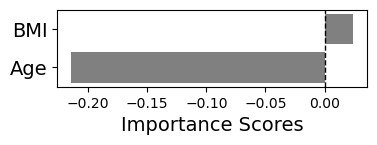

In [10]:
### clinical feature Importance score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bmi_scores = np.array([attributions[1][i, :][0].cpu().detach().tolist() for i in range(len(candidate_sample))])
age_scores = np.array([attributions[1][i, :][1].cpu().detach().tolist() for i in range(len(candidate_sample))])
sex_scores = np.array([attributions[1][i, :][2].cpu().detach().tolist() for i in range(len(candidate_sample))])

# 创建 DataFrame
data = pd.DataFrame({
    'BMI': bmi_scores,
    'Age': age_scores,
})

# summary
absolute_mean_values = data.sum()

# barplot
plt.figure(figsize=(4, 1))
sns.barplot(y=absolute_mean_values.index, x=absolute_mean_values.values, color='grey')

plt.title('', fontsize=16)
plt.xlabel('Importance Scores', fontsize=14)
plt.ylabel('', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.grid(False)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
# plt.savefig("/pool1/liujianhong/prj/20250103_interpretation/04.interpretation/meta_IS_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [11]:
### load gene symbol list

gene_list = []
with open(r"../00.preprocessing/GeneRanks_within_scPIT.txt","r")as f:
    for line in f:
        fline = line.strip().split("\t")
        gene_list.append(fline[0])

sample_gene_importance = {}
for sample_idx in range(len(sample_list)):
    sample = sample_list[sample_idx]
    gene_importance = attributions[0][sample_idx:sample_idx+1].sum(dim=1).squeeze().cpu().detach().numpy()  # [genes]
    sample_gene_importance.setdefault(sample, gene_importance)


In [12]:
### Importance score of genes
import pandas as pd

importance_scores = np.array([scores for scores in sample_gene_importance.values()])
df = pd.DataFrame(importance_scores, columns=gene_list, index=sample_list)
df.to_csv('importance_scores.csv') # save gene importance score

average_importance = importance_scores.sum(axis=0)  # shape: (4118,)

sorted_indices = np.argsort(average_importance) 

sorted_genes = [gene_list[i] for i in sorted_indices] 
sorted_importance = average_importance[sorted_indices]
# print
print("Ranked:")
print(sorted_genes[:20])
print(sorted_genes[-20:])
print("importance score:")
print(sorted_importance[:20].tolist())
print(sorted_importance[-20:].tolist())
print(max(sorted_importance))
print(min(sorted_importance))

Ranked:
['ATP1B3', 'PDE4D', 'FTH1', 'ZNF331', 'NFKBIA', 'GNLY', 'YES1', 'SLC39A8', 'INTS6', 'S100A4', 'LDLRAD4', 'RBM47', 'TALAM1', 'HSP90AA1', 'SFTPA1', 'ELL2', 'CEBPD', 'IFITM2', 'DNAJB1', 'HLA-DPB1']
['HEXIM1', 'PITPNC1', 'CLEC2B', 'AOAH', 'XIST', 'DUSP1', 'NKG7', 'RIPOR2', 'SERPINB1', 'CST3', 'PLIN2', 'HLA-DRB5', 'POLR2A', 'CCL5', 'SLC2A3', 'CELF2', 'SYNE2', 'SIPA1L1', 'SFTPC', 'FOS']
importance score:
[-3.871999740600586, -3.2560811042785645, -2.5435287952423096, -2.450293779373169, -2.381274700164795, -2.3139395713806152, -2.117133617401123, -1.8786821365356445, -1.87782883644104, -1.8326385021209717, -1.8241848945617676, -1.7367233037948608, -1.6335679292678833, -1.6132264137268066, -1.5811587572097778, -1.5673174858093262, -1.4570491313934326, -1.3837299346923828, -1.3599025011062622, -1.359207034111023]
[1.3604499101638794, 1.395866870880127, 1.4245052337646484, 1.4391294717788696, 1.4566011428833008, 1.4575194120407104, 1.4819068908691406, 1.5652539730072021, 1.57294869422912

In [13]:
### Importance score of genes grouped by celltypes
print(attributions[0].shape)
print(celltype.shape)
print(sample_mask.shape)

import pandas as pd
### 样本维度池化，得到cell types * genes
all_sample = {}
for idx in range(len(sample_list)):
    sample = sample_list[idx]
    sample_is = attributions[0][idx][sample_mask[idx].cpu()==False]
    sample_celltype = celltype[idx][sample_mask[idx].cpu()==False]
    all_sample.setdefault(sample, [sample_is, sample_celltype])
# 新字典，用于存储结果
all_sample_celltype = {}
# 遍历每个样本
for sample_name, (cells_genes, cell_types) in all_sample.items():
    # 确保输入是Tensor
    cells_genes = torch.tensor(cells_genes)  # [cells, genes]
    cell_types = torch.tensor(cell_types)   # [cells]
    # 获取基因数和细胞类型的数目
    genes = cells_genes.shape[1]
    num_cell_types = 14  # 细胞类型从0到13
    # 初始化 [14, genes] 的矩阵，用于存储每个细胞类型的均值
    cell_type_means = torch.zeros((num_cell_types, genes))
    # 遍历每个细胞类型 (0-13)，计算每个类型的均值
    for cell_type in range(num_cell_types):
        # 找到当前细胞类型的索引
        indices = (cell_types == cell_type).nonzero(as_tuple=True)[0]
        if len(indices) > 0:  # 如果该类型存在细胞
            # 提取该细胞类型对应的基因表达数据
            selected_cells = cells_genes[indices]
            # 计算均值，并赋值到结果矩阵中
            cell_type_means[cell_type] = selected_cells.mean(dim=0)
        else:
            # 如果该类型没有细胞，保持0不变
            pass
    # 将结果加入到新字典中
    all_sample_celltype[sample_name] = cell_type_means

# 获取样本数量
num_samples = len(all_sample_celltype)
# 获取基因数量，假设取第一个样本的 genes 数量
genes = next(iter(all_sample_celltype.values())).shape[1]
# 初始化 [14, genes] 的零矩阵用于存储合并结果
merged_matrix = torch.zeros((14, genes))
# 遍历字典中的每个样本
for sample_name, cell_type_matrix in all_sample_celltype.items():
    merged_matrix += cell_type_matrix  # 累加每个样本的 [14, genes]
# 计算均值，确保避免除以0
if num_samples > 0:
    merged_matrix /= num_samples
# 输出合并后的矩阵
celltype_list = ["AT2", "Alveolar macrophage", "CD4+ T", "CD8+ T", "Classical monocyte", "Interstitial macrophage", "Mast", "Mature AT1", "NK", "NKT", "Non-classical monocyte", "Venous", "cDC2", "gCap"]
df = pd.DataFrame(merged_matrix.numpy(), index=celltype_list, columns=gene_list)
df.to_csv("Celltype_Genes_IS.csv")


torch.Size([10, 2891, 4118])
torch.Size([10, 2891])
torch.Size([10, 2891])


/tmp/ipykernel_3216289/3426822405.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cells_genes = torch.tensor(cells_genes)  # [cells, genes]
/tmp/ipykernel_3216289/3426822405.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cell_types = torch.tensor(cell_types)   # [cells]


In [14]:
### valid_importance_matrices 
valid_importance_matrices = []
for i in range(attributions[0].shape[0]):
    valid_cell_importance = attributions[0][i].sum(dim=1)[sample_mask[i].cpu() == False] # 基因维度加和，求单个细胞IS
    
    # Z-score 标准化
    mean = valid_cell_importance.mean()
    std = valid_cell_importance.std()
    valid_cell_importance = (valid_cell_importance - mean) / std  # Z-score 归一化

    valid_importance_matrices.append(valid_cell_importance)
valid_importance = torch.cat(valid_importance_matrices, dim=0).cpu().detach().numpy()
print(valid_importance.shape)

(10279,)


In [15]:
### celltype label
valid_celltype_matrices = []
for i in range(len(celltype)):
    valid_celltype = celltype[i][sample_mask[i].cpu() == False]
    valid_celltype_matrices.append(valid_celltype)
valid_celltype = torch.cat(valid_celltype_matrices, dim=0).cpu().tolist()
print(len(valid_celltype))
print(valid_celltype)
label = {0:"AT2", 1:"Alveolar macrophage", 2:"CD4+ T", 3:"CD8+ T", 4:"Classical monocyte", 5:"Interstitial macrophage", 6:"Mast", 7:"Mature AT1", 8:"NK", 9:"NKT", 10:"Non-classical monocyte", 11:"Venous", 12:"cDC2", 13:"gCap"}
label = [label[item] for item in valid_celltype]
print(len(label))
print(len(set(label)))

10279
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [16]:
### disease label
valid_group_matrices = []
group_label = []
for i in range(len(celltype)):
    vaild_group = celltype[i][sample_mask[i].cpu() == False]
    group = candidate_sample_disease_group[i]
    if group == 1:
        group = "COPD"
    else:
        group = "Control"
    valid_group_matrices.extend([group] * len(vaild_group))
    group_label.extend([candidate_sample_disease_group[i]] * len(vaild_group))
print(len(valid_group_matrices))
print(valid_group_matrices)
print(len(group_label))
print(group_label)
    

10279
['COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', '

In [17]:
### ！！
import torch
import numpy as np

valid_gene_matrices = []

for i in range(attributions[0].shape[0]):
    valid_gene_matrix = attributions[0][i][sample_mask[i] == False]
    valid_gene_matrices.append(valid_gene_matrix)
valid_gene_matrix_combined = torch.cat(valid_gene_matrices, dim=0)

gene_matrix_reshaped = valid_gene_matrix_combined.view(-1, valid_gene_matrix_combined.shape[-1]).detach().cpu().numpy()
print(gene_matrix_reshaped.shape)

(10279, 4118)


In [18]:
###!!! Flatten cell importance to match UMAP embeddings
cell_importance_flat = valid_importance.flatten()  # Shape: [num_samples * num_cells,]
print(cell_importance_flat.shape)

(10279,)


/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


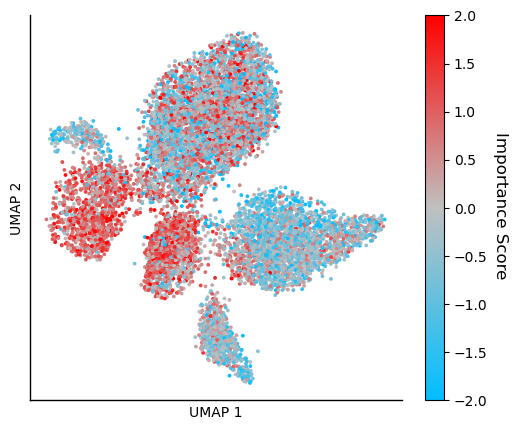

In [ ]:
### UMAP， colored by importance score
# import numpy as np
import umap
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrowPatch
# Calculate UMAP embeddings
umap_model = umap.UMAP(n_neighbors=50, min_dist=0.8, metric='euclidean', random_state=42)
umap_embeddings = umap_model.fit_transform(gene_matrix_reshaped)
# Flatten cell importance to match UMAP embeddings
cell_importance_flat = valid_importance.flatten()  # Shape: [num_samples * num_cells,]
# color mapping
cmap = LinearSegmentedColormap.from_list('red_white_blue', ['deepskyblue', 'silver', 'red'], N=256)
# alpha mapping
abs_importance = np.abs(cell_importance_flat)
clipped_importance = np.clip(abs_importance, 0, 1)
norm = Normalize(vmin=0, vmax=1)
alpha_values = norm(clipped_importance)
# Plot UMAP embeddings
fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=cell_importance_flat,  # Directly use the flattened importance scores
    cmap=cmap,
    # alpha=alpha_values,
    s=3,
    vmin=-2,
    vmax=2
)
# color bar
cbar = plt.colorbar(scatter, ax=ax, label='')
ax.set_yticks([])
ax.set_xticks([])

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(1)
    ax.spines[spine].set_color('black')


ax.set_title("")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
fig.text(0.91, 0.5, 'Importance Score', fontsize=12, rotation=-90, va='center', ha='center')

plt.show()
# plt.savefig("../sc_umap_IS.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("../sc_umap_IS.png", format="png", bbox_inches="tight")


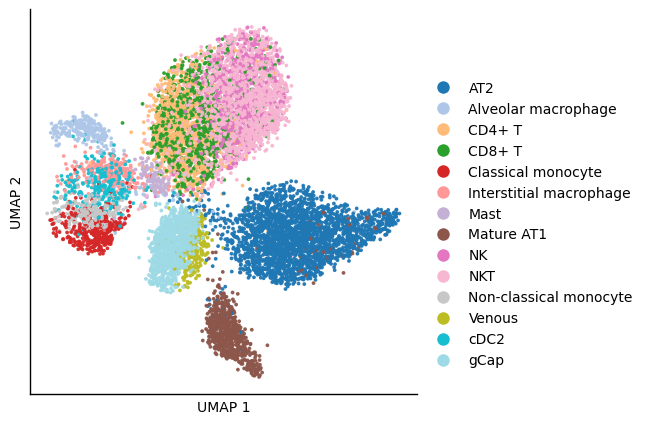

In [ ]:
### UMAP， colored by celltype
from sklearn.preprocessing import LabelEncoder
from matplotlib.gridspec import GridSpec
label_encoder = LabelEncoder()
label_encoder.fit(label)


fig = plt.figure(figsize=(5, 5))
gs = GridSpec(8, 8, figure=fig, wspace=0.1, hspace=0.1)
ax_main = fig.add_subplot(gs[0:8, 0:8])
scatter = ax_main.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=valid_celltype,
    cmap='tab20',
    alpha=0.9,
    s=3
)
ax_main.set_xlabel("UMAP 1")
ax_main.set_ylabel("UMAP 2")
ax_main.set_yticks([])
ax_main.set_xticks([])

# board
for spine in ['top', 'right']:
    ax_main.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax_main.spines[spine].set_linewidth(1)
    ax_main.spines[spine].set_color('black')

# legend
handles = [
    plt.Line2D(
        [0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10
    )
    for i in range(len(label_encoder.classes_))
]
fig.legend(
    handles,
    label_encoder.classes_,
    title="",
    loc='center left',
    bbox_to_anchor=(.9, 0.45),
    ncol=1,
    frameon=False
)

fig.text(0.5, 0.9, '', fontsize=12, rotation=0, va='center', ha='center')
# plt.savefig("../sc_umap_CellType.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("../sc_umap_CellType.png", format="png", bbox_inches="tight")
plt.show()

In [21]:
print(len(cell_importance_flat))
print(len(label))
print(len(valid_group_matrices))

10279
10279
10279


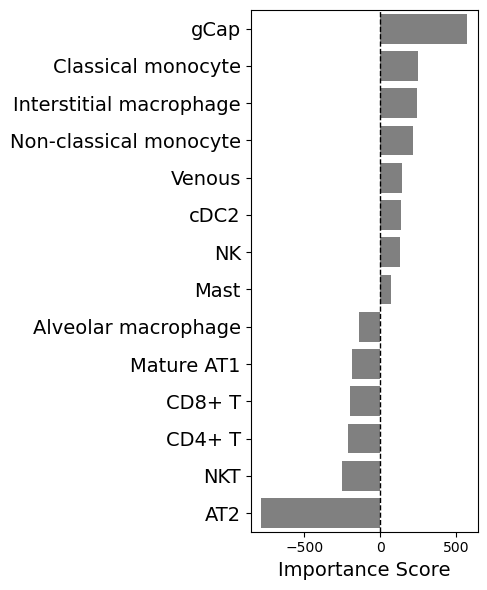

In [ ]:
### bar plot of importance score grouped by cell type
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
data = pd.DataFrame({
    'Importance': cell_importance_flat,
    'CellType': label,
})
# count importance score per cell type
mean_importance = data.groupby('CellType')['Importance'].sum().reset_index() # sum
mean_importance['AbsoluteImportance'] = mean_importance['Importance'].abs()
mean_importance = mean_importance.sort_values(by='Importance', ascending=False)
# bar plor
plt.figure(figsize=(5, 6))
sns.barplot(y='CellType', x='Importance', data=mean_importance, color="grey")

plt.title('', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
y_axis_label = plt.ylabel('', fontsize=14, labelpad=20)
y_axis_label.set_position((1.05, 0.5))
y_axis_label.set_horizontalalignment('center')
plt.xticks(fontsize=10)
plt.yticks(fontsize=14)
plt.grid(False)
plt.tight_layout()
# plt.savefig("../CellType_IS.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("../CellType_IS.png", format="png", bbox_inches="tight")
plt.show()

/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 39.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnin

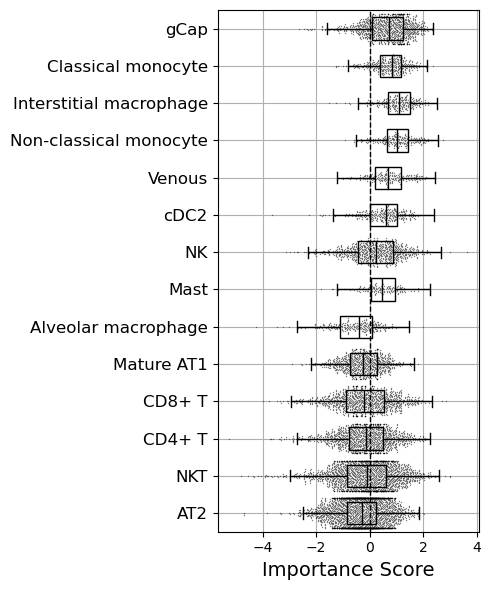

In [ ]:
### box plot of importance score grouped by cell type
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Create DataFrame
data = pd.DataFrame({
    'Importance': cell_importance_flat,
    'CellType': label,
})
# Calculate median importance for each cell type and sort in descending order
median_importance = data.groupby('CellType')['Importance'].sum().reset_index() # sum
median_importance = mean_importance.sort_values(by='Importance', ascending=False)
median_sorted_types = median_importance["CellType"].tolist()

# box plot
plt.figure(figsize=(5, 6))  # Increased figure size for better readability
# Create box plot with custom order based on median importance
sns.boxplot(y='CellType', x='Importance', data=data, 
            color='white', 
            width=0.6,  # Adjust box width
            showfliers=False,  # Hide outliers to prevent overcrowding
            order=median_sorted_types, 
            boxprops=dict(facecolor='white', edgecolor='black'),  # Ensure white fill with black outline
            medianprops=dict(color='black'),  # Black median line
            whiskerprops=dict(color='black'),  # Black whiskers
            capprops=dict(color='black'))  # Sort cell types by median importance
# individual points
sns.swarmplot(y='CellType', x='Importance', data=data, 
              color='black', 
              size=1,  # Adjust point size
              alpha=0.5,  # Add some transparency
              order=median_sorted_types)  # Ensure same order as boxplot

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('', fontsize=14)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
# plt.savefig("../CellType_IS_boxplot.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("../CellType_IS_boxplot.png", format="png", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3216289/2143378655.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = data.groupby(['CellType', 'Importance_Binned']).size().unstack(fill_value=0)


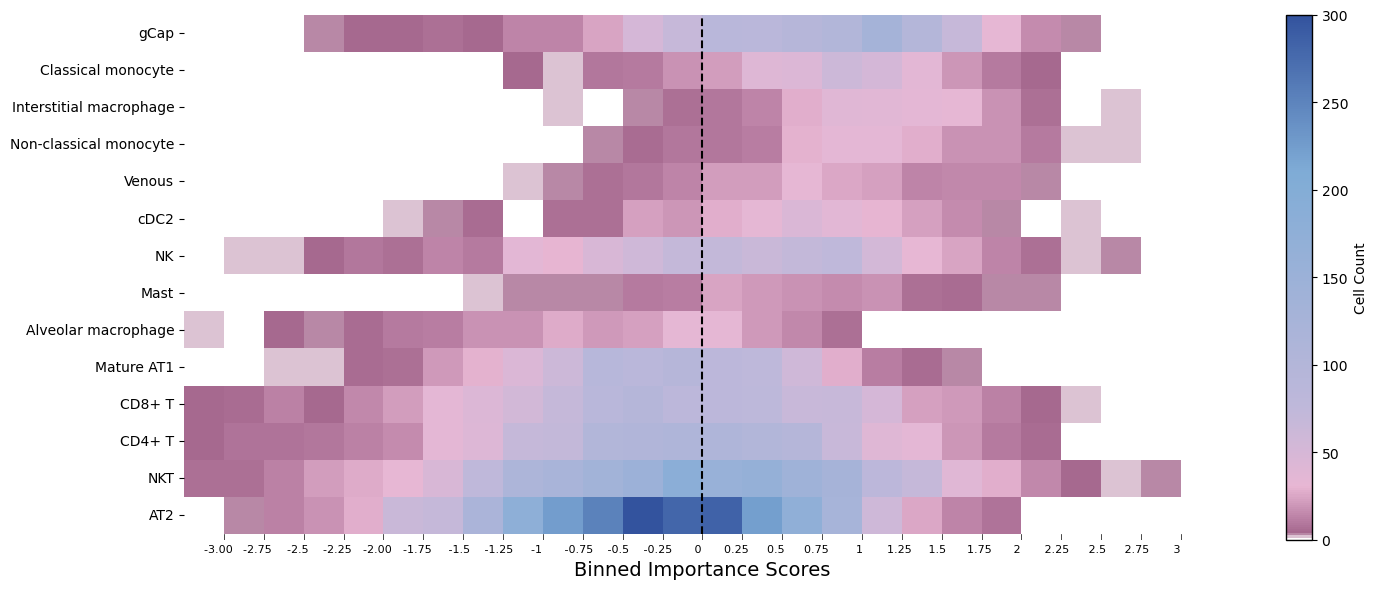

In [ ]:
### heatmap of importance score grouped by celltype
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# binned
bins = [-3.25,-3,-2.75,-2.5,-2.25,-2,-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25]
xrtckslabels = ['        -3.00', '        -2.75', '        -2.5', '        -2.25', '        -2.00',
                '        -1.75', '         -1.5', '         -1.25', '        -1', '         -0.75', '         -0.5', '         -0.25', '         0', 
                '        0.25','        0.5','        0.75','          1', '          1.25', '         1.5', '          1.75',  '         2',
                '         2.25', '         2.5', '         2.75', '         3',""]
# order
cell_type_order = mean_importance['CellType'].tolist()

data['Importance_Binned'] = pd.cut(data['Importance'], bins=bins, labels=xrtckslabels, right=True)
heatmap_data = data.groupby(['CellType', 'Importance_Binned']).size().unstack(fill_value=0)
heatmap_data = heatmap_data.reindex(median_sorted_types)
# heatmap color bar
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    (0.0, "white"),
    (0.01, "#A5678E"),
    (0.1, "#E8B7D4"),
    (0.25, "#BFB8DA"),
    (.7, "#7FACD6"),
    (1, "#33539E")
])
# plot
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(heatmap_data,
                      fmt='d',
                      cmap=custom_cmap,
                      cbar_kws={'label': 'Cell Count'},
                      linewidths=0.6,
                      linecolor=None,
                      vmin=0,
                      vmax=300)
colorbar = heatmap.collections[0].colorbar
colorbar.outline.set_edgecolor('black')
colorbar.outline.set_linewidth(1)

plt.title('', fontsize=16)
plt.xlabel('Binned Importance Scores', fontsize=14)
plt.ylabel('', fontsize=14)

plt.tick_params(axis='x', which='both', length=0)

plt.xticks(ticks=np.arange(len(xrtckslabels)) + 0.5, labels=xrtckslabels, rotation=0, fontsize=8)

ax = plt.gca()
ax.set_ylim(14.15, 0)
for tick, label in zip(np.arange(len(xrtckslabels)-1), xrtckslabels):
    ax.plot([tick+1, tick+1], [14.3, 14], color='black', linewidth=0.5)
ax.plot([13, 13], [14, 0], color='black', linewidth=1.5,linestyle='--')
plt.tight_layout()
plt.grid(False)
# plt.savefig("../CellType_IS_Heatmap.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("../CellType_IS_Heatmap.png", format="png", bbox_inches="tight")
plt.show()